<a href="https://colab.research.google.com/github/AhamedShimak/AhamedShimak/blob/main/MakeMe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Shimak generator

###imports

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split

###GPU 

In [ ]:
!nvidia-smi
print(torch.cuda.is_available())
#setup device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)


/bin/bash: nvidia-smi: command not found
False
cpu


# Load Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2

def convert_video_to_images(video_path, output_path):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = video_capture.read()
        if not success:
            break

        output_file = f"{output_path}/{frame_count}.jpg"
        cv2.imwrite(output_file, frame)

        frame_count += 1

    video_capture.release()

# Usage example

convert_video_to_images("/content/drive/MyDrive/AI/shimak.mp4", output_path="/content/drive/MyDrive/AI/shimak")



###data transforms / for good perfomance

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize image to (224, 224)
    #transforms.TrivialAugmentWide(2),

    transforms.ToTensor(),  # Convert PIL image to tensor
    #transforms.RandomHorizontalFlip(0.5) # Normalize image tensor
])

In [ ]:
from torchvision import datasets
trainset=datasets.ImageFolder(root="/content/drive/MyDrive/AI/data",transform=data_transform, target_transform=None)

1302

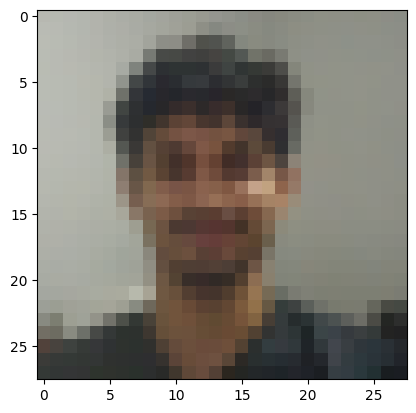

In [ ]:
image,label=trainset[7]
plt.imshow(image.squeeze().permute(1,2,0))
len(trainset)

# Data load / batch ready!

In [ ]:
batch_size=128

In [ ]:
trainloader=DataLoader(trainset,batch_size=batch_size, shuffle=True)

In [ ]:
len(trainloader)

11

torch.Size([3, 28, 28])
tensor(0)


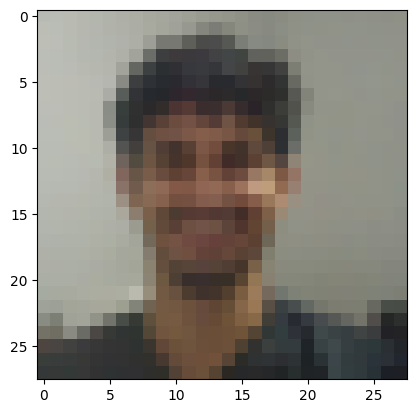

In [ ]:
images, label = next(iter(trainloader))
print(images[0].shape)
#print(images[0])
plt.imshow(images[0].permute(1,2,0))
print(label[0])

In [ ]:
# plot in sub plots //grayscale

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

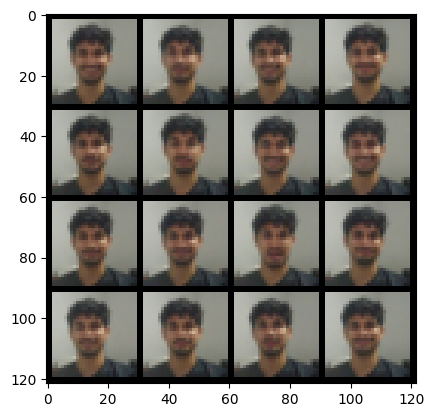

In [ ]:
show_tensor_images(images)

# Building the model | Discriminator

In [197]:
def get_disc_block(in_channels, out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0,2)
  )

In [213]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 =get_disc_block(3,16,(3,3),2)
    self.block_2 =get_disc_block(16,32,(5,5),2)
    self.block_3 =get_disc_block(32,64,(5,5),2)

    self.classifier=nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 64,out_features=1)
    )
  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.classifier(self.block_3(self.block_2(self.block_1(x))))

In [214]:
D= Discriminator()
D.to(device)
summary(D, input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             448
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,833
Trainable params: 64,833
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

# Create Generator Network 

In [215]:
def get_gen_block(in_channels, out_channels, kernel_size,stride):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [216]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim=noise_dim
    self.block_1 =get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 =get_gen_block(256,128,(4,4),1)
    self.block_3 =get_gen_block(128,64,(3,3),2)

    self.image_gen_block=nn.Sequential(
        nn.ConvTranspose2d(64,3,(4,4),2),
        nn.Sigmoid(),
    )
  def forward(self, r_noise_dim):
    x= r_noise_dim.view(-1,self.noise_dim,1,1)
    return self.image_gen_block(self.block_3(self.block_2(self.block_1(x))))

In [217]:
noise_dim=500
G= Generator(noise_dim)
G.to(device)
summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]       1,152,256
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 3, 28, 28]           3,075
          Sigmoid-11            [-1, 3, 28, 28]               0
Total params: 1,754,435
Trainable params: 1,754,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [218]:
# Replace Random initialized weights to Normal weights  
def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [219]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Optimizer



In [205]:
# optim para

lr=0.001
beta_1=0.5
beta_2=0.99



In [220]:
D_opt=torch.optim.Adam(D.parameters(),lr=0.001,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=0.005,betas=(beta_1,beta_2))

# Training Loop 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 | D_loss:0.6920314810492776 | G_loss1.1072337952527134


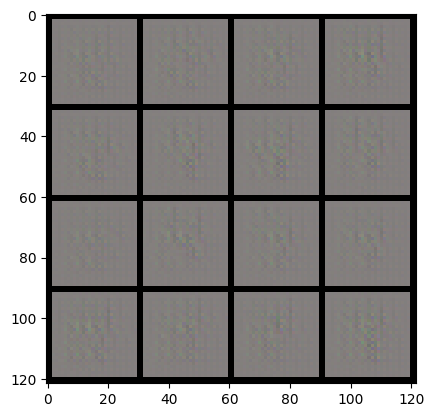

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2 | D_loss:0.6888700723648071 | G_loss1.0855466560883955


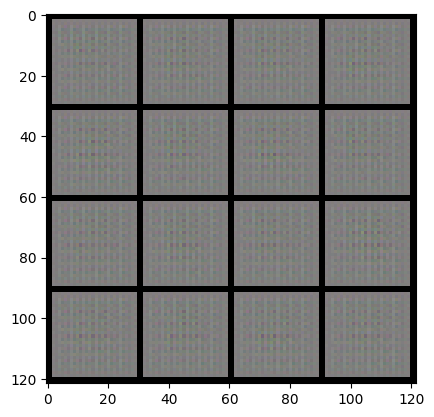

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3 | D_loss:0.6837797219103033 | G_loss1.073974696072665


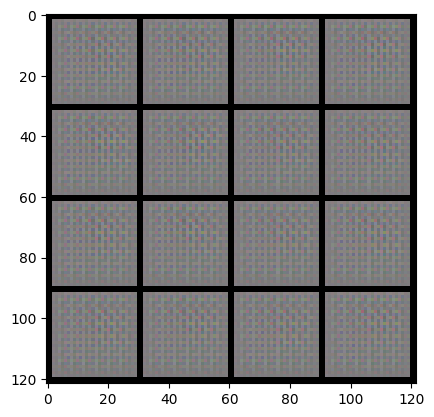

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4 | D_loss:0.6755271391435103 | G_loss1.0691587166352705


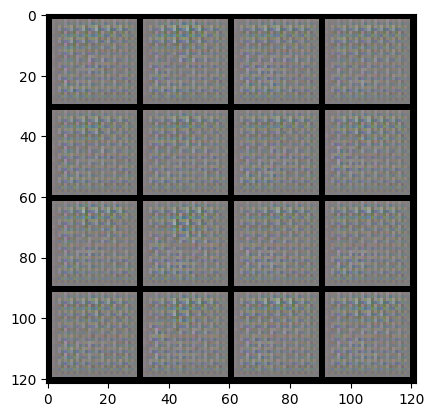

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5 | D_loss:0.6658952181989496 | G_loss1.083463571288369


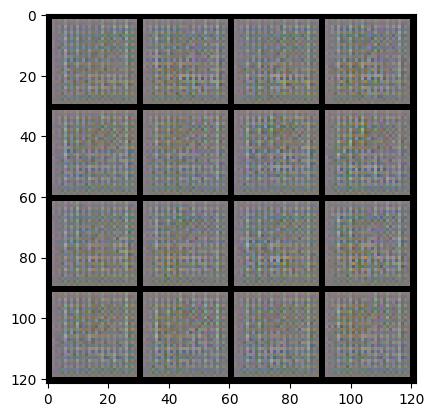

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6 | D_loss:0.6550099199468439 | G_loss1.1176357919519597


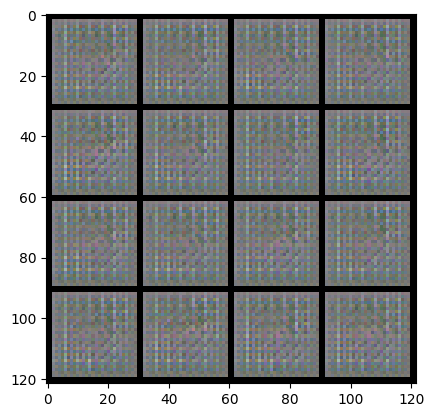

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7 | D_loss:0.6415123506025835 | G_loss1.1592890457673506


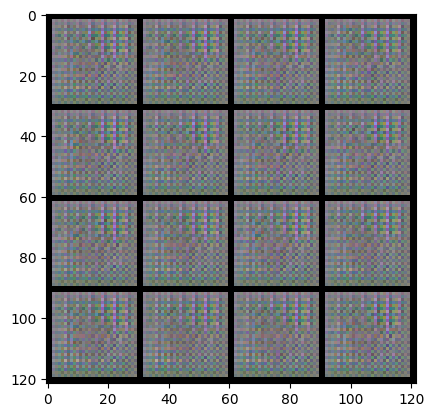

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8 | D_loss:0.6225688836791299 | G_loss1.2123600352894177


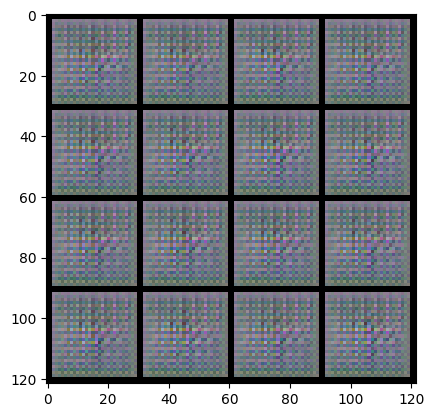

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9 | D_loss:0.6132910576733676 | G_loss1.273201205513694


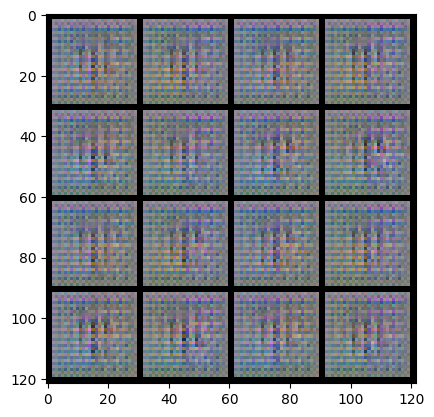

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10 | D_loss:0.5907952731305902 | G_loss1.3457937457344749


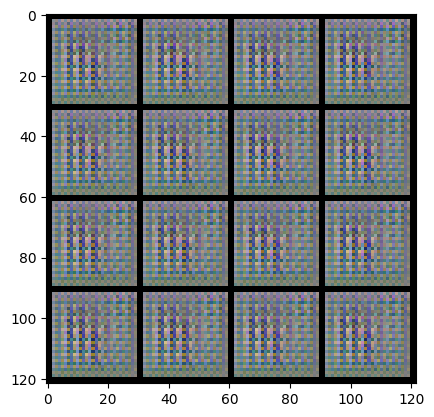

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11 | D_loss:0.5733405460010875 | G_loss1.46029916676608


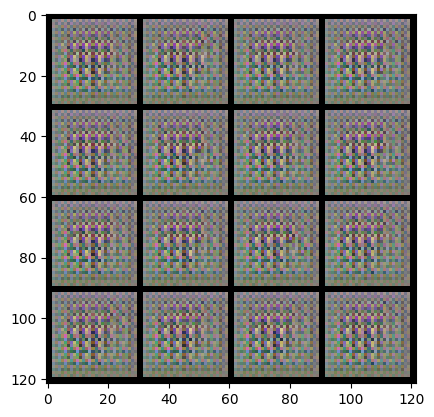

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12 | D_loss:0.5463778105649081 | G_loss1.6231207955967297


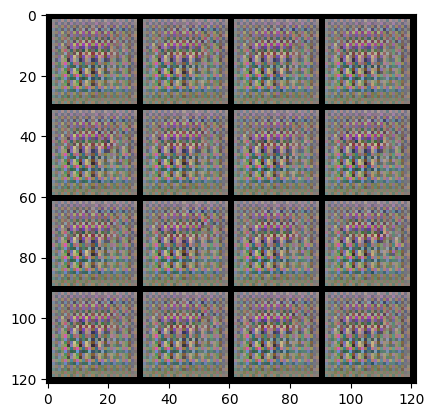

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13 | D_loss:0.5262445753270929 | G_loss1.7877486510710283


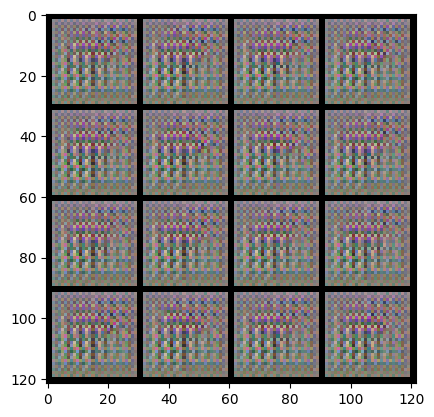

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14 | D_loss:0.5106171261180531 | G_loss1.9357088262384587


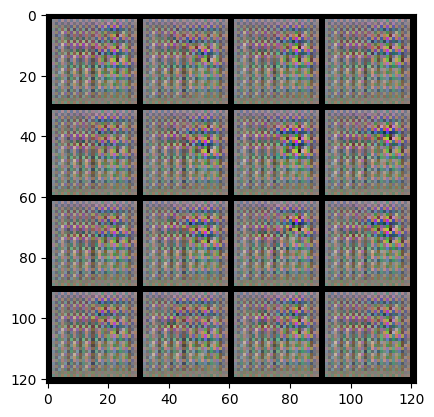

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15 | D_loss:0.5463826114481146 | G_loss2.0103018934076484


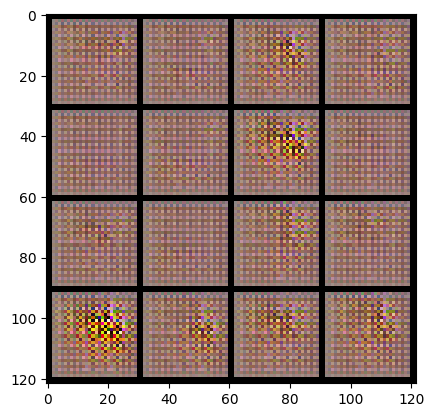

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16 | D_loss:0.4823537143793973 | G_loss2.2653252211484043


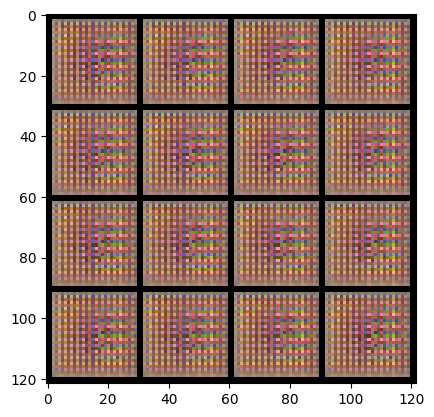

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17 | D_loss:0.5152417909015309 | G_loss2.428399151021784


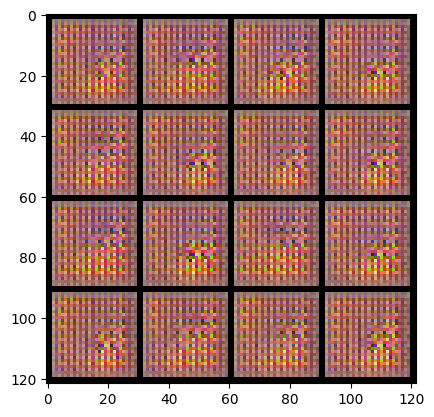

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18 | D_loss:0.4377399412068454 | G_loss2.5695745944976807


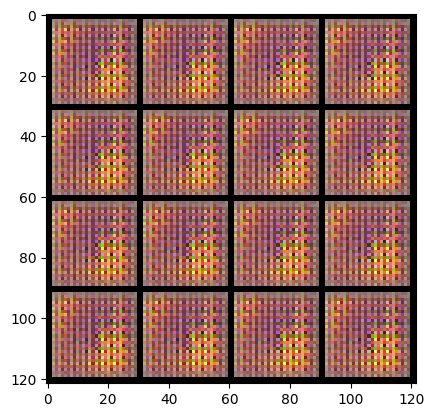

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19 | D_loss:0.4248009107329629 | G_loss2.546686432578347


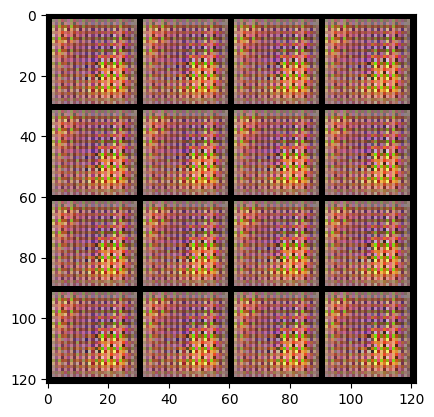

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 20 | D_loss:0.4007649773901159 | G_loss2.8501099889928643


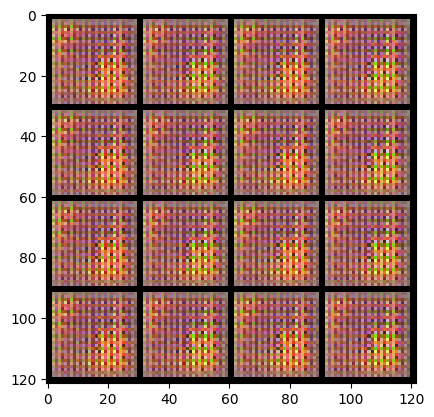

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 21 | D_loss:0.39589386636560614 | G_loss2.968656886707653


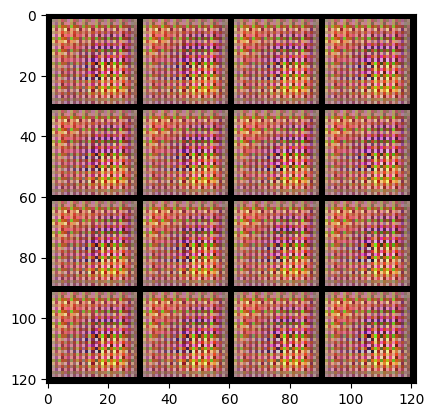

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 22 | D_loss:0.3683480349454013 | G_loss3.214735507965088


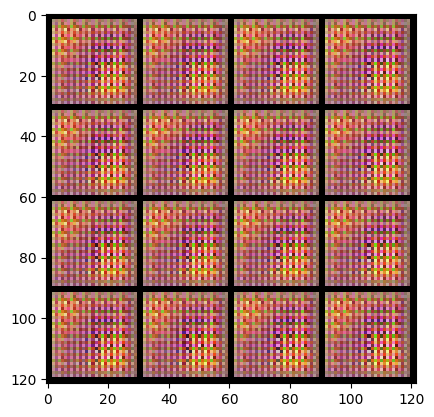

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 23 | D_loss:0.341813632033088 | G_loss3.48825682293285


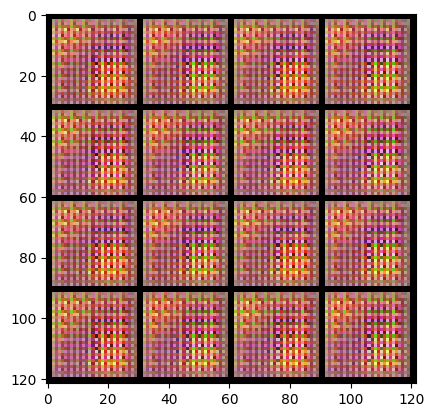

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 24 | D_loss:0.32332226092165167 | G_loss3.7661690061742608


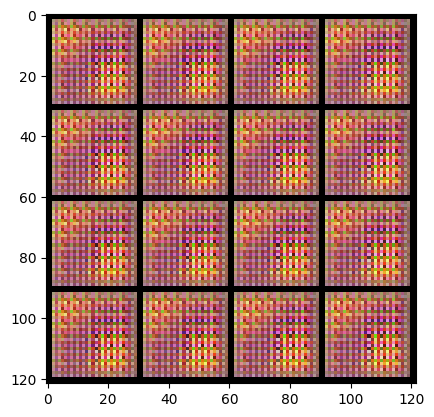

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 25 | D_loss:0.3069632893258875 | G_loss4.047213922847401


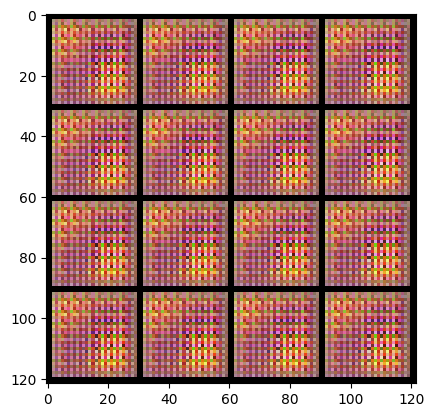

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 26 | D_loss:0.2890160869468342 | G_loss4.276578209616921


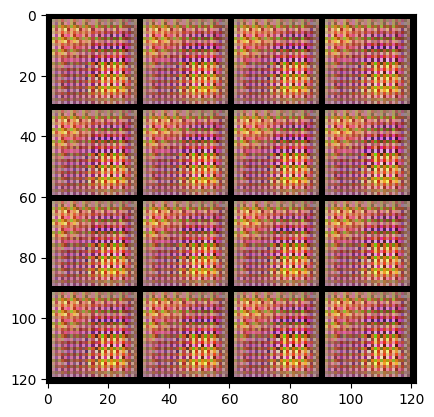

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 27 | D_loss:0.2723773148926822 | G_loss4.5942910367792305


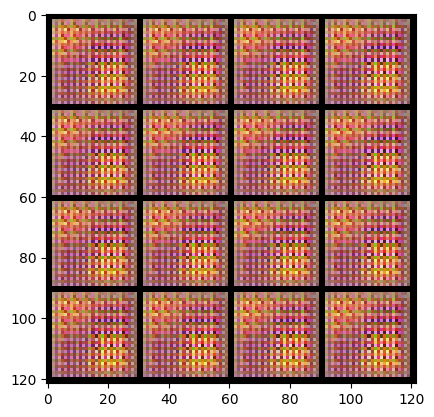

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 28 | D_loss:0.2614045739173889 | G_loss4.837487740950151


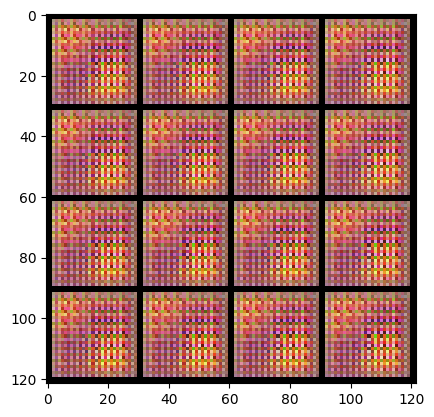

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 29 | D_loss:0.24245298586108469 | G_loss5.134564399719238


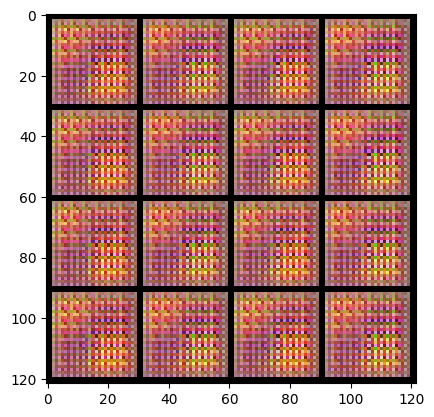

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 30 | D_loss:0.227767676115036 | G_loss5.503504623066295


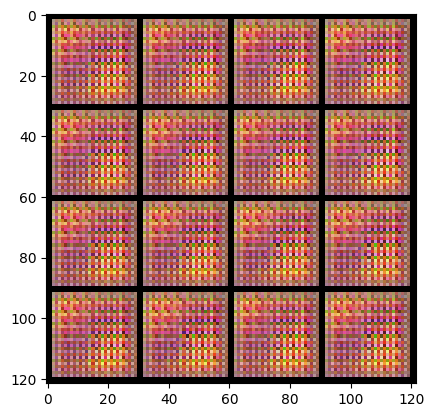

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 31 | D_loss:0.21776531772180038 | G_loss5.75509786605835


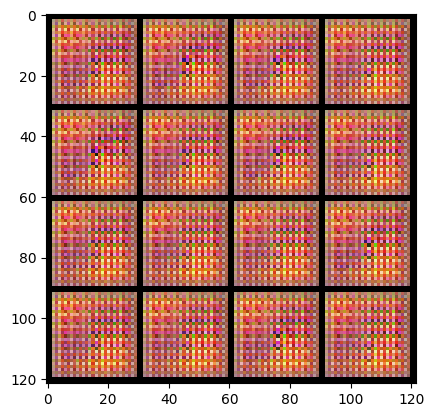

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [221]:
G_loss_track=[]
D_loss_track=[]
def real_loss(disc_pred):
  loss_func=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred) #creating zeros with matching size of disc_pred
  loss =loss_func(disc_pred,ground_truth)
  return loss

def real_loss_g(disc_pred):
  loss_func=nn.MSELoss()
  ground_truth=torch.ones_like(disc_pred) #creating zeros with matching size of disc_pred
  loss =loss_func(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  loss_func=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred) #creating zeros with matching size of disc_pred
  loss =loss_func(disc_pred,ground_truth)
  return loss

#training_var
epochs=100

for  i in range(epochs):
  total_d_loss=0.0
  total_g_loss=0.0

  for real_img, _ in tqdm(trainloader):
    real_img= real_img.to(device)#####
    noise=torch.randn(batch_size,noise_dim,device = device)

    #pred_discriminator
    fake_img=G(noise)#####
    D_pred=D(fake_img)

    #loss_calculation
    D_loss_to_increase=fake_loss(D_pred)

    D_pred=D(real_img)
    D_loss_to_reduce=real_loss(D_pred)

    
    D_loss=(D_loss_to_increase + D_loss_to_reduce)/2

    total_d_loss += D_loss.item()


    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()

    #generator_side #################################
    noise=torch.randn(batch_size,noise_dim,device = device)

    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss_g(D_pred)

    total_g_loss += G_loss.item()

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()
  
  avg_d_loss=total_d_loss/len(trainloader)
  avg_g_loss=total_g_loss/len(trainloader)
  G_loss_track.append(avg_g_loss)
  D_loss_track.append(avg_d_loss)
  print("Epoch: {} | D_loss:{} | G_loss{}".format(i+1, avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)

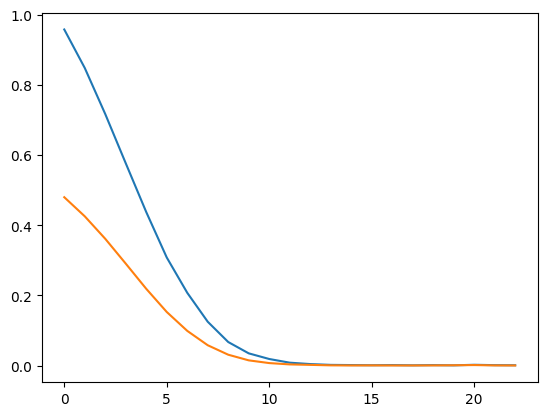

In [181]:
  plt.plot(G_loss_track)
plt.plot(D_loss_track)

In [144]:
avg_g_loss

0.00023292791510440028

##EVALUATION

In [130]:
fake_img[0].shape

torch.Size([3, 28, 28])

In [134]:
real_img[0]

tensor([[[0.7333, 0.7333, 0.7333,  ..., 0.5804, 0.5765, 0.5686],
         [0.7451, 0.7451, 0.7373,  ..., 0.5843, 0.5765, 0.5725],
         [0.7490, 0.7412, 0.7373,  ..., 0.5882, 0.5843, 0.5804],
         ...,
         [0.3412, 0.3098, 0.2784,  ..., 0.1804, 0.1765, 0.1412],
         [0.2392, 0.2314, 0.2314,  ..., 0.1765, 0.1765, 0.1529],
         [0.2275, 0.2235, 0.2196,  ..., 0.1843, 0.1255, 0.1059]],

        [[0.7451, 0.7451, 0.7412,  ..., 0.5804, 0.5765, 0.5765],
         [0.7569, 0.7529, 0.7451,  ..., 0.5882, 0.5843, 0.5804],
         [0.7608, 0.7529, 0.7451,  ..., 0.5922, 0.5922, 0.5882],
         ...,
         [0.2784, 0.2824, 0.2863,  ..., 0.2157, 0.2000, 0.1647],
         [0.2510, 0.2431, 0.2431,  ..., 0.2157, 0.2039, 0.1804],
         [0.2392, 0.2314, 0.2314,  ..., 0.2078, 0.1412, 0.1216]],

        [[0.7176, 0.7176, 0.7137,  ..., 0.5529, 0.5451, 0.5333],
         [0.7294, 0.7255, 0.7137,  ..., 0.5529, 0.5490, 0.5529],
         [0.7333, 0.7255, 0.7137,  ..., 0.5569, 0.5529, 0.

In [133]:
fake_img[0]

tensor([[[0.5159, 0.5476, 0.4966,  ..., 0.5402, 0.5111, 0.5350],
         [0.5367, 0.5180, 0.5267,  ..., 0.4896, 0.5361, 0.5215],
         [0.5067, 0.5277, 0.4798,  ..., 0.4889, 0.5001, 0.5200],
         ...,
         [0.5480, 0.4912, 0.5426,  ..., 0.4394, 0.5383, 0.5088],
         [0.5300, 0.5274, 0.5180,  ..., 0.4986, 0.5198, 0.5204],
         [0.5490, 0.5013, 0.5556,  ..., 0.4740, 0.5438, 0.5172]],

        [[0.4907, 0.4989, 0.4696,  ..., 0.4707, 0.4798, 0.4877],
         [0.4848, 0.5008, 0.4744,  ..., 0.4725, 0.5032, 0.4907],
         [0.4837, 0.4990, 0.4374,  ..., 0.4261, 0.4550, 0.4633],
         ...,
         [0.4743, 0.4874, 0.4605,  ..., 0.4288, 0.5088, 0.4787],
         [0.4975, 0.5062, 0.4771,  ..., 0.4668, 0.4832, 0.4767],
         [0.4893, 0.4904, 0.4889,  ..., 0.4595, 0.5080, 0.4872]],

        [[0.4333, 0.4689, 0.4105,  ..., 0.4634, 0.4372, 0.4676],
         [0.4530, 0.4574, 0.4405,  ..., 0.4379, 0.4593, 0.4552],
         [0.4337, 0.4590, 0.3740,  ..., 0.4302, 0.4123, 0.

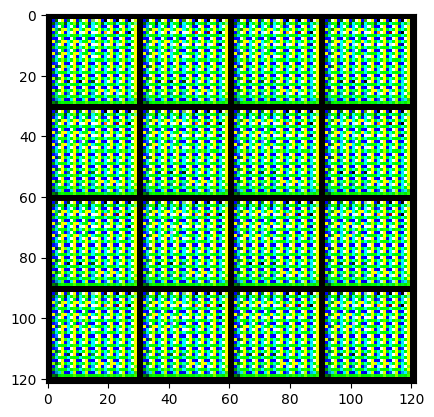

In [47]:
show_tensor_images(fake_img)

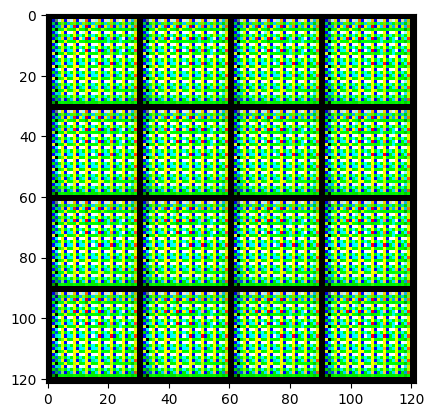

In [44]:
#Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)
show_tensor_images(generated_image)